<a href="https://colab.research.google.com/github/mariamoiuonalsoud/CodeAlpha_Stock_Prediciton/blob/main/StockPricePrediciton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
df = pd.read_csv('stock_prices.csv')
df = df[['Date', 'Close']]
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9670,2024-07-29,426.730011
9671,2024-07-30,422.920013
9672,2024-07-31,418.350006
9673,2024-08-01,417.109985


In [5]:
import datetime
#this function that convert the Date object type from String to DateTime
def str_to_datetime(s):
  split=s.split('-')
  year, month, day=int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [6]:
#call the function and convert the Date object type
df['Date']=df['Date'].apply(str_to_datetime)

In [7]:
print(df['Date'])


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9670   2024-07-29
9671   2024-07-30
9672   2024-07-31
9673   2024-08-01
9674   2024-08-02
Name: Date, Length: 9675, dtype: datetime64[ns]


In [8]:
#make the Date object the index
df.index=df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2024-07-29,426.730011
2024-07-30,422.920013
2024-07-31,418.350006


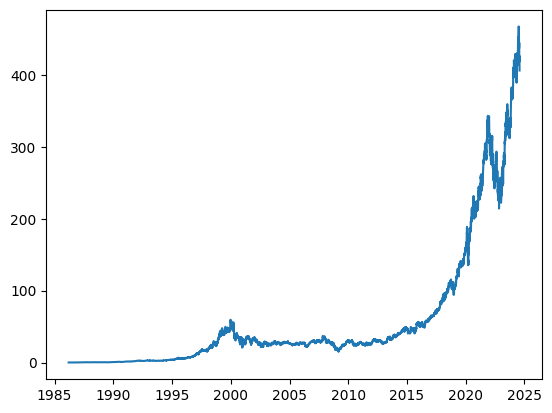

In [9]:
import matplotlib.pyplot as plt
#to see line plot visualization of our data
plt.plot(df.index, df['Close'])

In [51]:
import numpy as np
#to convert into a supervised learning problem to use LSTM model
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  #convert date strings to datetime objects
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = [] #list to store target dates
  X, Y = [], [] #lists to store input(X) and output(Y) data

  last_time = False
  while True:

    #extract a subset of the dataframe up to the target date
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    #extract the input and output sets
    #extract closing prices from the subset
    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date) #add target date to the list
    X.append(x) #add input data to the X
    Y.append(y) #add output data to the Y

    #find the next target date (one week ahead)
    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True


  #create a new DataFrame to store the results

  #convert the lists to numpy arrays
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i] #add input features to the DataFrame

  ret_df['Target'] = Y #add output target to the DataFrame

  return ret_df

# Start day second time around: '2021-03-25' until '2022-03-25'
windowed_df = df_to_windowed_df(df,
                                '2022-08-02',
                                '2024-08-02',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2022-08-02,276.410004,280.739990,278.010010,274.820007
1,2022-08-03,280.739990,278.010010,274.820007,282.470001
2,2022-08-04,278.010010,274.820007,282.470001,283.649994
3,2022-08-05,274.820007,282.470001,283.649994,282.910004
4,2022-08-08,282.470001,283.649994,282.910004,280.320007
...,...,...,...,...,...
499,2024-07-29,428.899994,418.399994,425.269989,426.730011
500,2024-07-30,418.399994,425.269989,426.730011,422.920013
501,2024-07-31,425.269989,426.730011,422.920013,418.350006
502,2024-08-01,426.730011,422.920013,418.350006,417.109985


In [52]:
#convert target-1, target-2, target-3 into numpy arrays
def windowed_df_to_date_X_Y(windowed_dataframe):
  #convert whole data frame into a numpy array
  df_as_np=windowed_dataframe.to_numpy()

  #to get the dates
  dates = df_as_np[:,0]

  middle_matrix=df_as_np[:,1:-1]
  X=middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y=df_as_np[:,-1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, x, y = windowed_df_to_date_X_Y(windowed_df)

dates.shape,x.shape, y.shape

((504,), (504, 3, 1), (504,))

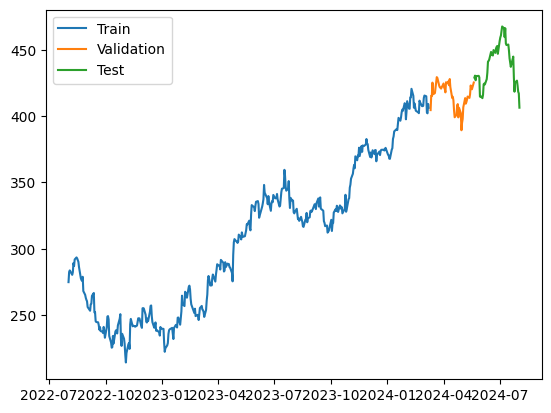

In [53]:
#to split the data inot train validation and testing partitions
q_80 = int(len(dates) * 0.8)
q_90 = int(len(dates) * 0.9)

dates_train, x_train, y_train = dates[:q_80], x[:q_80], y[:q_80]

dates_val, x_val, y_val = dates[q_80:q_90], x[q_80:q_90], y[q_80:q_90]

dates_test, x_test, y_test = dates[q_90:], x[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

# **Create The Model**

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3,1)), # 3 days in the past, 1 feature only
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=130)

#early_stopping = EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True)

#history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=150,callbacks=[early_stopping])



Epoch 1/130
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 98345.2188 - mean_absolute_error: 308.8717 - val_loss: 171670.4844 - val_mean_absolute_error: 414.2200
Epoch 2/130
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 97557.0938 - mean_absolute_error: 307.3290 - val_loss: 171018.9219 - val_mean_absolute_error: 413.4328
Epoch 3/130
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 97316.0000 - mean_absolute_error: 306.8680 - val_loss: 169530.7969 - val_mean_absolute_error: 411.6291
Epoch 4/130
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 94410.0781 - mean_absolute_error: 302.1016 - val_loss: 166963.2344 - val_mean_absolute_error: 408.4984
Epoch 5/130
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 91029.1953 - mean_absolute_error: 296.7751 - val_loss: 163679.0938 - val_mean_absolute_error: 404.4586
Epoch 6/130
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 87338.6406 - mean_absolute_error: 290.7574 - val_loss: 158825.0469 - val_mean_absolute_error: 398.4127
Epoch 7/130
13/13 ━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


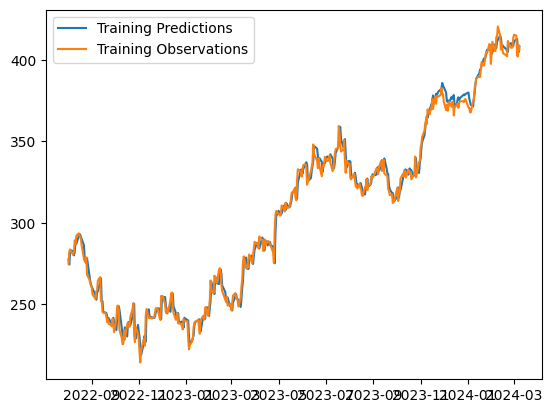

In [71]:
#This graphs visualize the actual observed observations
train_predictions = model.predict(x_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


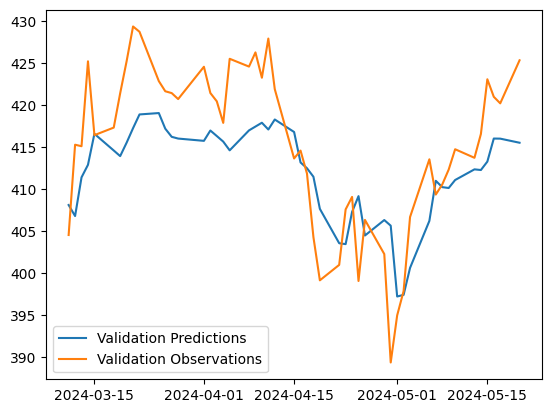

In [72]:
val_predictions = model.predict(x_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


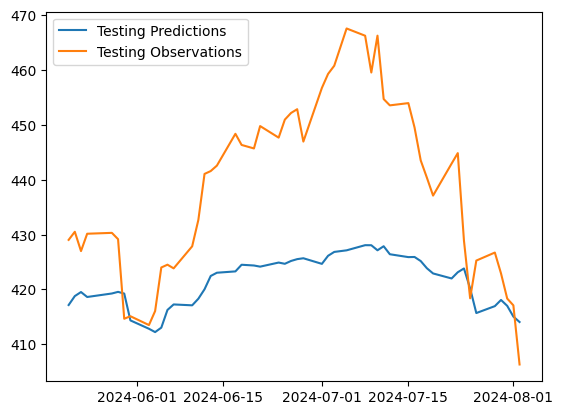

In [73]:
test_predictions = model.predict(x_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

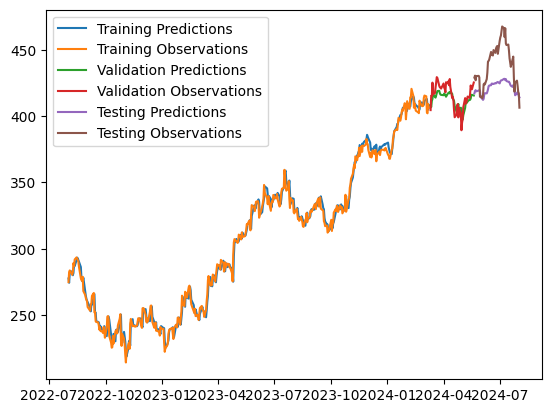

In [74]:
#putting the last three graphs in one graph
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 'Training Observations',
            'Validation Predictions', 'Validation Observations',
            'Testing Predictions', 'Testing Observations'])